# Reinforcement Learning Algorithms

<img src=https://www.researchgate.net/profile/Roohollah-Amiri/publication/323867253/figure/fig2/AS:606095550738432@1521515848671/Reinforcement-Learning-Agent-and-Environment.png alt="Reiforcement Learning arquitecture" width='400'>
Image source https://www.researchgate.net/figure/Reinforcement-Learning-Agent-and-Environment_fig2_323867253

The reinforcement learning model follows the image above. The main question regarding these algorithms is the exploitation of the best arm and exploration of all the others in order to find the one with best reward.

This notebook has the implementation of 4 different bandits:

1. Upper Confidence Bound Bandit (UCB)
2. Random Bandit
3. E-Greedy Bandit
4. Thomspon Sampling Bandit

Each use different techniques of exploration/exploitation. The explanation of every algorithm is before its' respective class code. A comparison between all of them is on the end of the notebook.

The arms are probabilities of a 1 or 0 reward on a beta distribution. For this experiment 10 arms were chosen. 

In [1]:
# imports on libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random.mtrand import RandomState

In [2]:
# set random state, number of iterations, quantity of arms and arms distribuiton based on a beta distribution
np.random.RandomState(12)

iterations = 2000
arm_qtd = 10
arms = [np.random.beta(1.4, 5.4) for i in range(arm_qtd)]
arms

#prob_distr = np.random.normal(1, 0.5, 10)
#print(prob_distr)

[0.36324002098677244,
 0.08356520347142073,
 0.14124100603062947,
 0.04681749411877064,
 0.6428114354277216,
 0.21112867199912244,
 0.029282781428494113,
 0.21770285911726517,
 0.46591478478217263,
 0.4876449108806814]

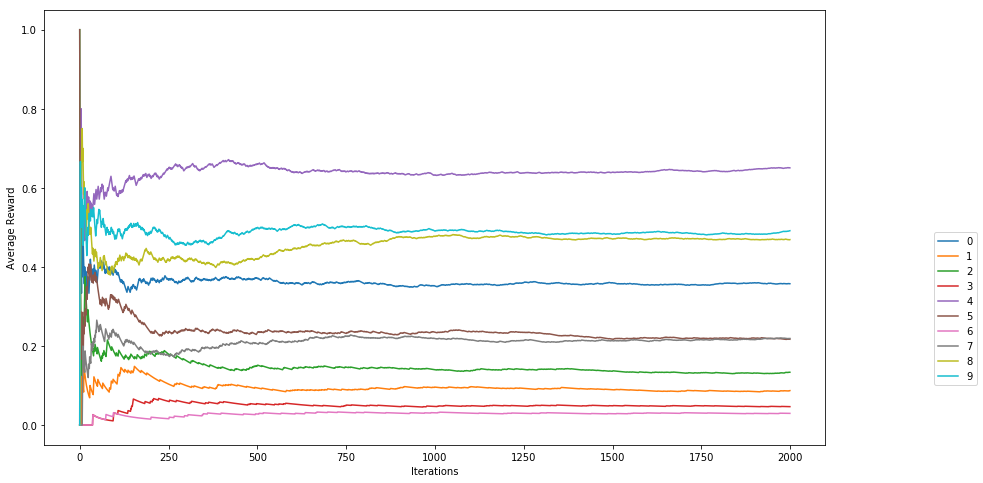

In [3]:
# print arms probabilities of return 1 as reward
data = []
plt.figure(figsize=(14, 8))
for i, a in enumerate(arms):
    i_rounds = np.array([i+1 for i in range(iterations)])
    values   = np.random.binomial(1, arms[i], iterations) #+ decay
    values   = np.cumsum(values)/i_rounds
    plt.plot(values, label=str(i))

plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.show()

## Base Class:

The implementation bellow represent a bandit class that will be inherited by all the others bandits. The pull function is specific for every algorithm.

In [4]:
class Bandit():
    def __init__(self, arms: list):
        """
        Base bandit constructor
        :param amrs: probability distribution of each arm
        """
        # quantity of arms
        self.narms = len(arms)
        # times each arm was used
        self.narms_n = np.ones(self.narms)
        # mean reward for each arm
        self.narms_rmean = np.zeros(self.narms)
        # total reward on each step
        self.reward = [0]
        # probability distribution of each arm
        self.arms = arms
        # n times that any arm was pulled 
        self.n = 1
        
    def pull():
        """
        Function that pulls one arm, get reward and update the total average reward of the bandit and arm average 
        """
        pass
    
    def __statistics(self, y_values: list, y_label: str, title: str, pos: int, color: str):
        """
        Function that creates a plot where x is the number of arms and y the average reward and times used of each arm
        :param y_values: list of values to be shown in bar plot
        :param y_label: label of y axis on the plot
        :param title: title of the plot
        :param pos: position on the subplot
        :para color: color of the bars
        """
        plt.subplot(2, 1, pos)
        x = [i for i in range(0, 10)]
        plt.title(title)
        plt.bar(x, y_values, align='center', color=color)
        plt.xlabel("Arm number")
        plt.ylabel(y_label)
        plt.xticks(x, fontsize=12)
        plt.yticks(fontsize=12)
    
    def show_statistics(self, name: str, color: str):
        """
        Function that plots the arms mean and quantity of pulls of each arm
        :param name: subplot name
        :param color: color of the bars of the plots
        """
        fig = plt.figure(figsize=(12,6))
        fig.suptitle(name)

        self.__statistics(self.narms_rmean, "Arms mean reward", "Average Arm Reward", 1, color)
        self.__statistics(self.narms_n, "Arms times used", "Pull Arm Quantity", 2, color)

        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

## 1 - Upper Confidence Bound (UCB) Algorithm:

The UCB algorithm uses the follow equation to handle the exploration/exploitation: 

\begin{align}
A_{t} = argmax_{a}(Q_{t}(a)) + c \sqrt{\frac{\ln{t}}{N_{t}(a)}}
\end{align}

where Qt(a) is the arm average reward, t the number of times that any arm was pulled and Nt(a) the number of times that an arm was pulled. The variable c is a parameter and can be ajusted to achieve the best results.

In [5]:
class UCBBandit(Bandit):
    def __init__(self, c: float, arms: list):
        """
        UCB Bandit constructor
        :param c: parameter of ucb formula
        """
        super().__init__(arms)
        # c parameter of ucb
        self.c = c
        
    def pull(self):
        # select arm based on ucb formula
        an = np.argmax(self.narms_rmean + self.c * (np.sqrt(np.log(self.n) / self.narms_n)))
        
        # get the reward from the arm
        reward = np.random.binomial(1, self.arms[an])
        
        # update average reward vector for bandit and arm selected
        self.reward.append(self.reward[-1] + ((reward - self.reward[-1]) / self.n)) 
        self.narms_rmean[an] = self.narms_rmean[an] + ((reward - self.narms_rmean[an]) / self.narms_n[an])
        
        # increase counters n of bandit and of arm selected
        self.n = self.n + 1
        self.narms_n[an] = self.narms_n[an] + 1
        

In [6]:
# test bandit for diferent c values
c_values = [0.25, 0.5, 1, 2, 4, 6]
results_ucb = {}

for index, c in enumerate(c_values):
    ucb = UCBBandit(c, arms)
    for i in range(iterations):
        ucb.pull()
    results_ucb[c] = ucb

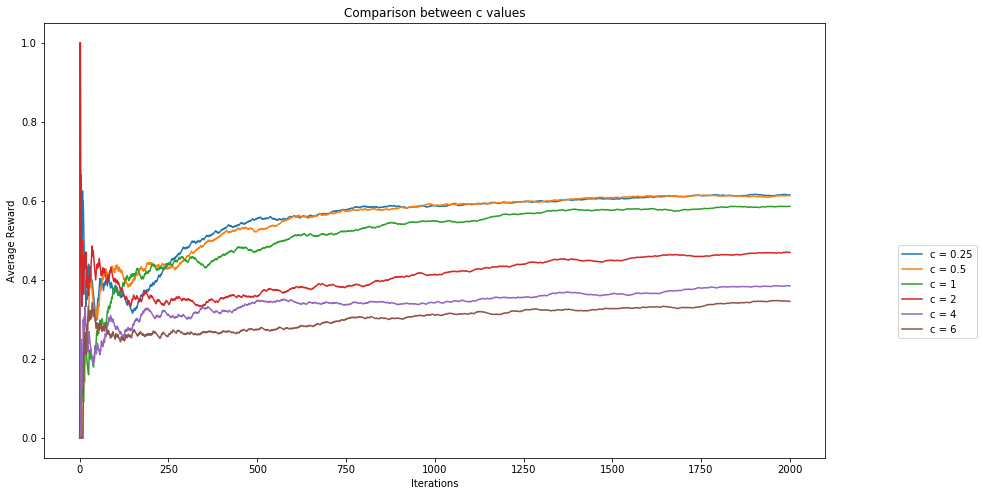

In [7]:
# plot rewards over the iteration and c value 
colors_ucb = {}

plt.figure(figsize=(14,8))
plt.title("Comparison between c values")
for c in c_values:
    p = plt.plot(results_ucb[c].reward, label="c = "+str(c))
    colors_ucb[c] = p[0].get_color()
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.show()

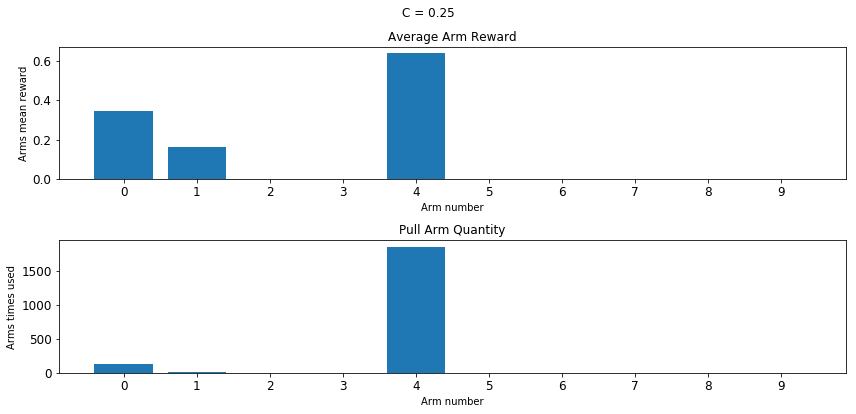

In [8]:
# plot results of c = 0.25
results_ucb[0.25].show_statistics("C = 0.25", colors_ucb[0.25])

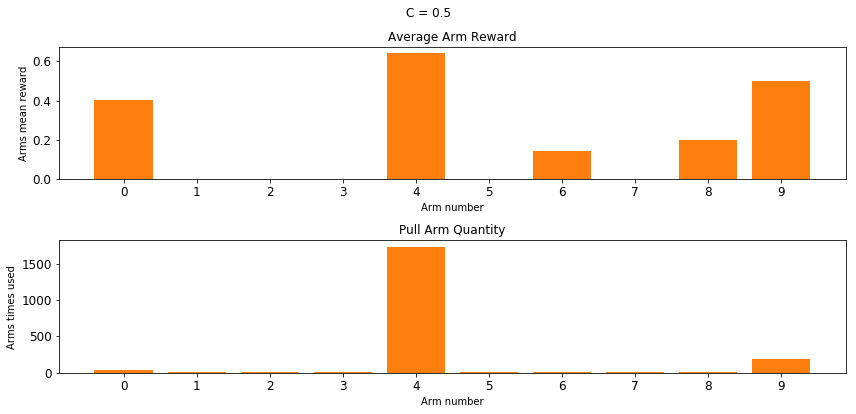

In [9]:
# plot results of c = 0.5
results_ucb[0.5].show_statistics("C = 0.5", colors_ucb[0.5])

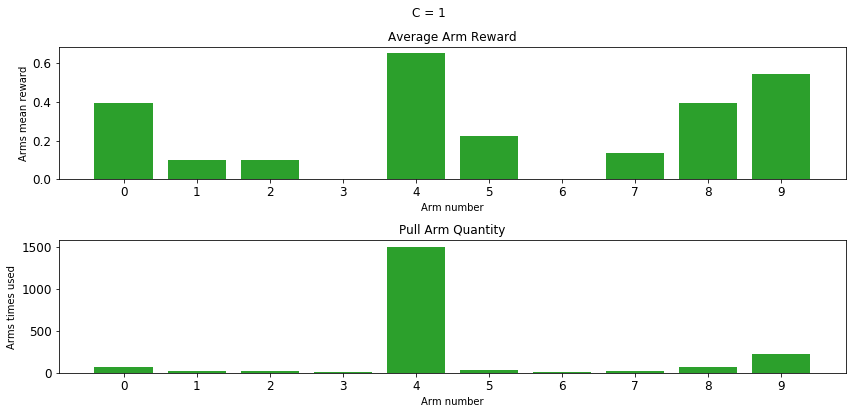

In [10]:
# plot results of c = 1
results_ucb[1].show_statistics("C = 1", colors_ucb[1])

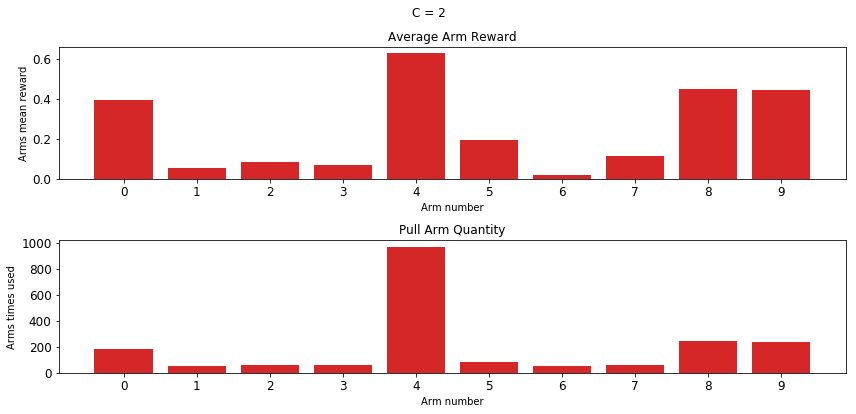

In [11]:
# plot results of c = 2
results_ucb[2].show_statistics("C = 2", colors_ucb[2])

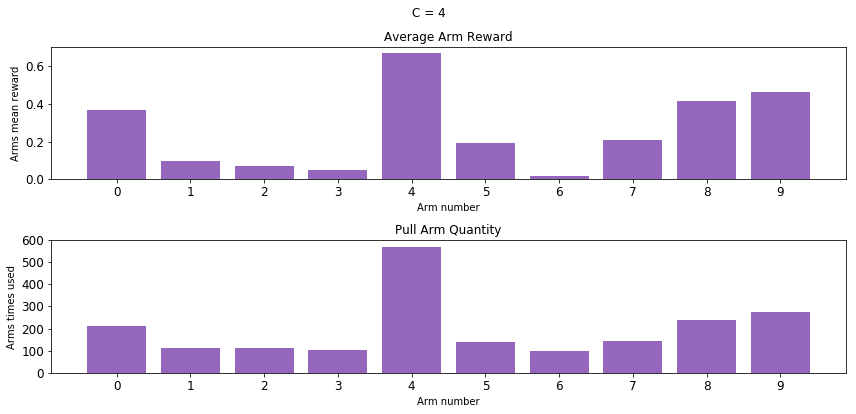

In [12]:
# plot results of c = 4
results_ucb[4].show_statistics("C = 4", colors_ucb[4])

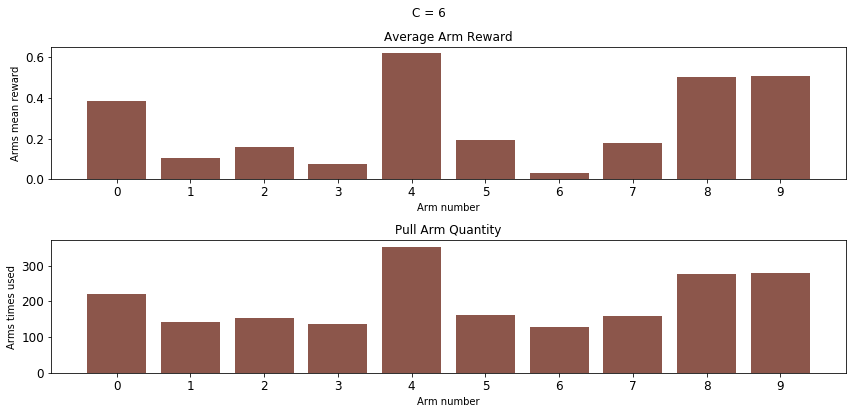

In [13]:
# plot results of c = 6
results_ucb[6].show_statistics("C = 6", colors_ucb[6])

## 2 - Random Algorithm:

The random algorithm chooses any arm randomly from any of the available ones.

In [14]:
# Random Bandit 
class RandomBandit(Bandit):
    def __init__(self, arms):
        super().__init__(arms)
        
    def pull(self):
        # select arm randomly
        an = np.random.randint(0, self.narms)
        
        # get the reward from the arm
        reward = np.random.binomial(1, self.arms[an])
        
        # update average reward vector for bandit and arm selected
        self.reward.append(self.reward[-1] + ((reward - self.reward[-1]) / self.n)) 
        self.narms_rmean[an] = self.narms_rmean[an] + ((reward - self.narms_rmean[an]) / self.narms_n[an])
        
        # increase counters n of bandit and of arm selected
        self.n = self.n + 1
        self.narms_n[an] = self.narms_n[an] + 1
        

In [15]:
# pull arms of random bandit
rand_b = RandomBandit(arms)
for i in range(iterations):
        rand_b.pull()

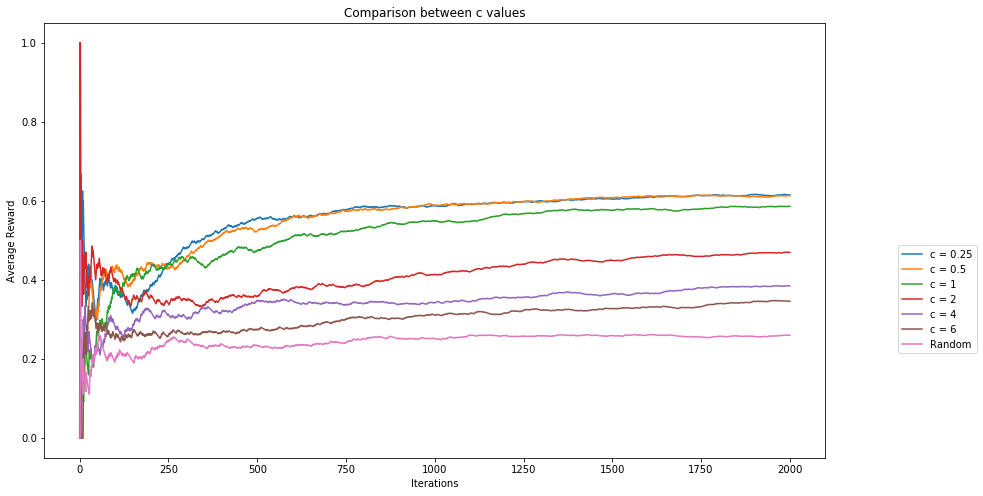

In [16]:
# plot rewards over the iteration and c value 
plt.figure(figsize=(14,8))
plt.title("Comparison between c values")
for c in c_values:
    p = plt.plot(results_ucb[c].reward, label="c = "+str(c))

p = plt.plot(rand_b.reward, label="Random")
rand_color = p[0].get_color()

plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.show()

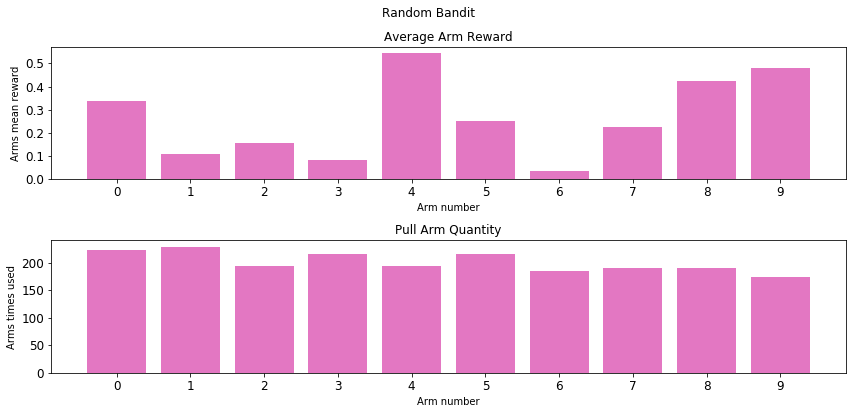

In [17]:
# show arm analysis of random bandit
rand_b.show_statistics("Random Bandit", rand_color)

## 3 - E-Greedy Algorithm

The E-greedy algorithm has a parameter e and it follows the pseudocode:

1. select a random number p betweeen 0 and 1
2. if number is smaller than e explore and select random arm
3. else exploit arm with best mean reward

In [18]:
# Random Bandit 
class EGreedyBandit(Bandit):
    def __init__(self, eps, arms):
        super().__init__(arms)
        self.eps = eps
        
    def pull(self):
        # select arm based on e-greedy rule: if random value is less than p, use random arm, else, use best arm so far 
        p = np.random.random()
        
        if p < self.eps or self.n == 0 or self.eps == 0:
            an = np.random.randint(0, self.narms)
        else:
            an = np.argmax(self.narms_rmean)
        
        # get the reward from the arm
        reward = np.random.binomial(1, self.arms[an])
        
        # update average reward vector for bandit and arm selected
        self.reward.append(self.reward[-1] + ((reward - self.reward[-1]) / self.n)) 
        self.narms_rmean[an] = self.narms_rmean[an] + ((reward - self.narms_rmean[an]) / self.narms_n[an])
        
        # increase counters n of bandit and of arm selected
        self.n = self.n + 1
        self.narms_n[an] = self.narms_n[an] + 1

In [19]:
# test bandit for diferent c values
eps_values = [0, 0.01, 0.1, 0.2, 0.5, 1]
results_eps = {}

for index, eps in enumerate(eps_values):
    epsgred = EGreedyBandit(eps, arms)
    for i in range(iterations):
        epsgred.pull()
    results_eps[eps] = epsgred

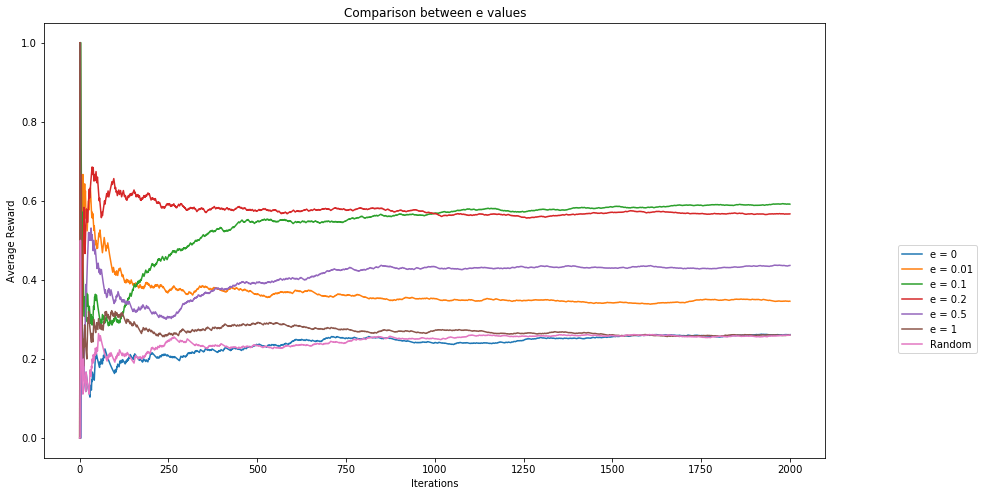

In [20]:
# plot rewards over the iteration and c value 
colors_eps = {}

plt.figure(figsize=(14,8))
plt.title("Comparison between e values")
for eps in eps_values:
    p = plt.plot(results_eps[eps].reward, label="e = "+str(eps))
    colors_eps[eps] = p[0].get_color()
    
p = plt.plot(rand_b.reward, label="Random")
rand_color = p[0].get_color()

plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.show()

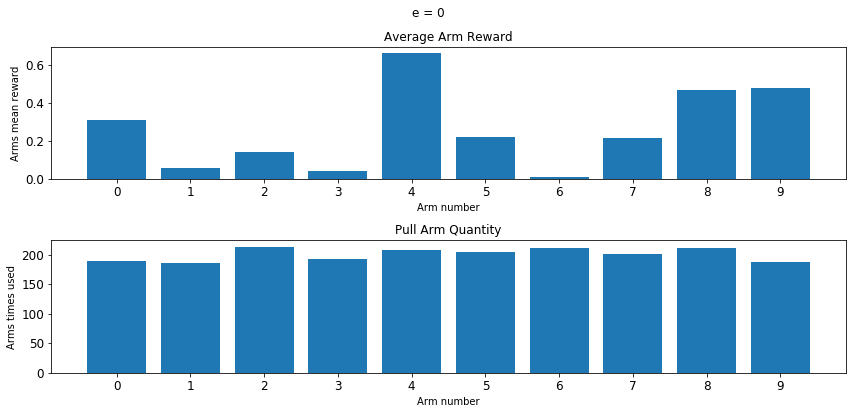

In [21]:
# plot results of e = 0
results_eps[0].show_statistics("e = 0", colors_eps[0])

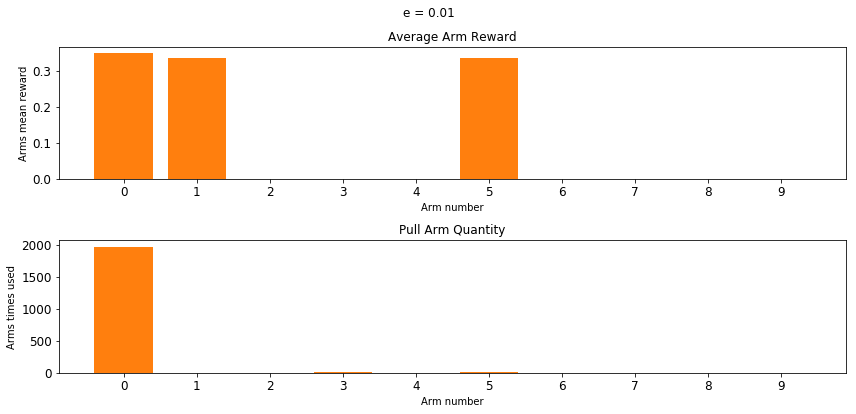

In [22]:
# plot results of e = 0.01
results_eps[0.01].show_statistics("e = 0.01", colors_eps[0.01])

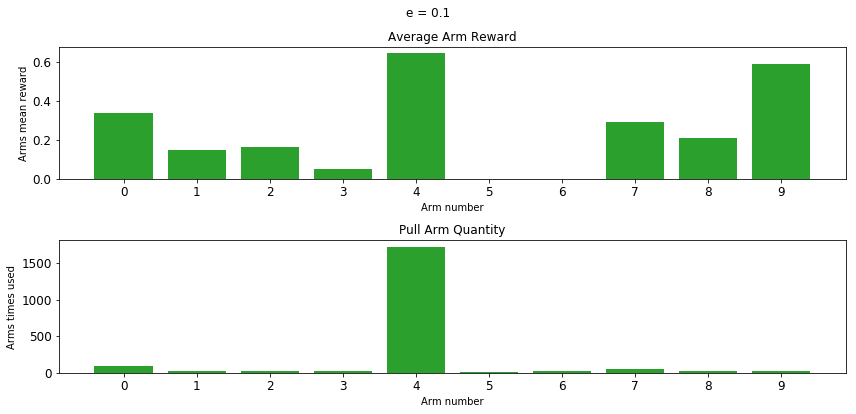

In [23]:
# plot results of e = 0.1
results_eps[0.1].show_statistics("e = 0.1", colors_eps[0.1])

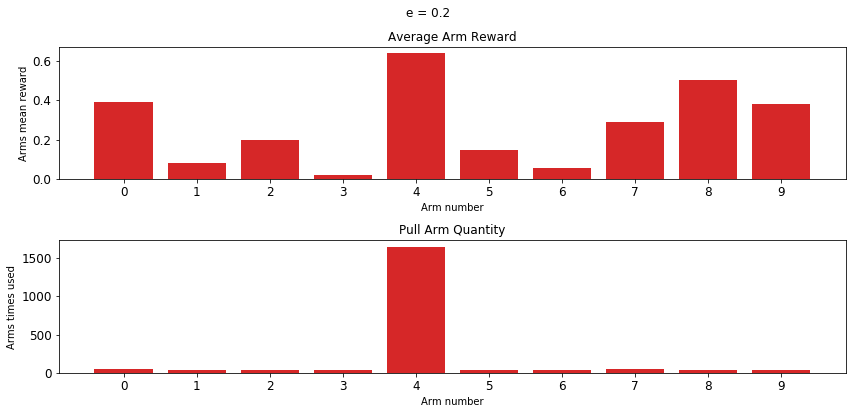

In [24]:
# plot results of e = 0.2
results_eps[0.2].show_statistics("e = 0.2", colors_eps[0.2])

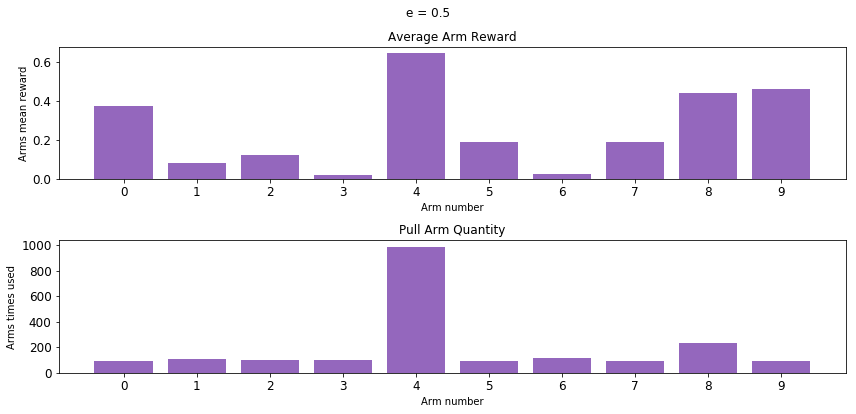

In [25]:
# plot results of e = 0.5
results_eps[0.5].show_statistics("e = 0.5", colors_eps[0.5])

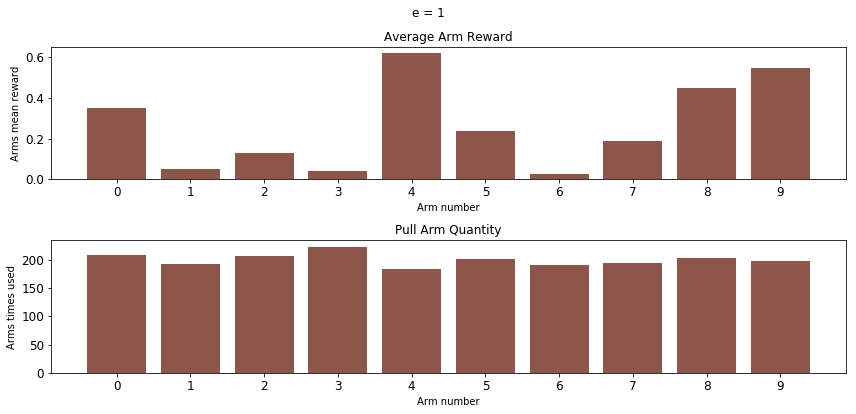

In [26]:
# plot results of e = 1
results_eps[1].show_statistics("e = 1", colors_eps[1])

## 4 - Thompson Sampling Bandit Algorithm

The Thompson Sampling bandit algorithm uses the beta distribution to estimate the reward of the arm. 

Therefore, for each arm an alpha and beta equal to one are assigned and the exploitation and exploration phase is based on the beta distribution value of each arm, based on each alpha and beta parameters of the beta distribution. The equation of the beta distribution follows: 

\begin{align}
f(x; \alpha, \beta) = \frac{\Gamma{(\alpha + \beta)}}{\Gamma{(\alpha)} \Gamma{(\beta)}} x^{\alpha - 1} (1-x)^{\beta - 1}
\end{align}

where the Gamma function for real numbers is defined by:

\begin{align}
\Gamma(n) = (n - 1)!
\end{align}

In [27]:
class ThompsonSamplingBandit(Bandit):
    def __init__(self, arms: list):
        super().__init__(arms)
        # alpha and beta parameters of beta distribution for each arm
        self.alpha = np.ones(self.narms)
        self.beta = np.ones(self.narms)
        
    def pull(self):
        # select arm based on ucb formula
        an = np.argmax([np.random.beta(self.alpha[i], self.beta[i]) for i in range(self.narms)])
        
        # get the reward from the arm
        reward = np.random.binomial(1, self.arms[an])
        
        # update average reward vector for bandit and arm selected
        self.reward.append(self.reward[-1] + ((reward - self.reward[-1]) / self.n)) 
        self.narms_rmean[an] = self.narms_rmean[an] + ((reward - self.narms_rmean[an]) / self.narms_n[an])
        
        # update beta and alpha for chosen arm
        self.alpha[an] = self.alpha[an] + reward
        self.beta[an]  = self.beta[an] + (1 - reward)
        
        # increase counters n of bandit and of arm selected
        self.n = self.n + 1
        self.narms_n[an] = self.narms_n[an] + 1

In [28]:
tsbandit = ThompsonSamplingBandit(arms)
for i in range(iterations):
    tsbandit.pull()

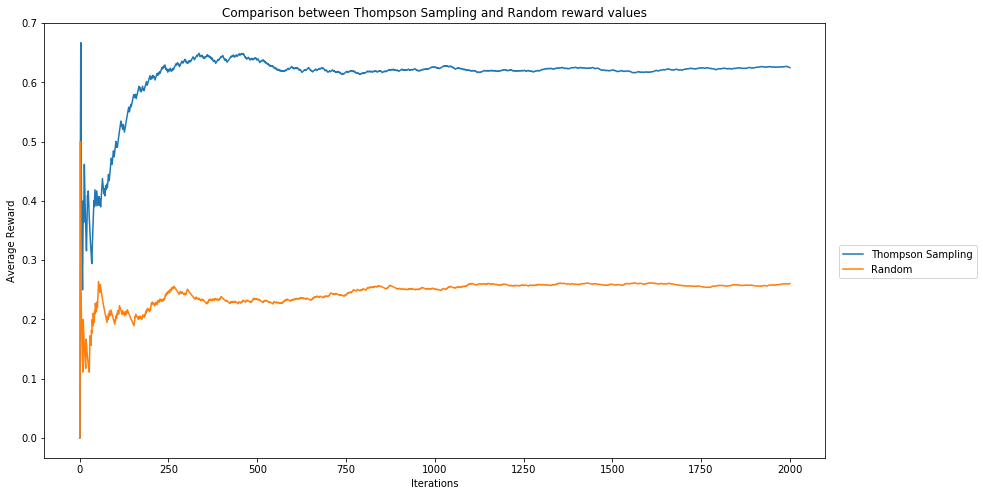

In [29]:
# plot rewards over the iteration
plt.figure(figsize=(14,8))
plt.title("Comparison between Thompson Sampling and Random reward values")

# thompson sampling
p = plt.plot(tsbandit.reward, label="Thompson Sampling")
color_thompson = p[0].get_color()
    
# random 
p = plt.plot(rand_b.reward, label="Random")
rand_color = p[0].get_color()

plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.show()

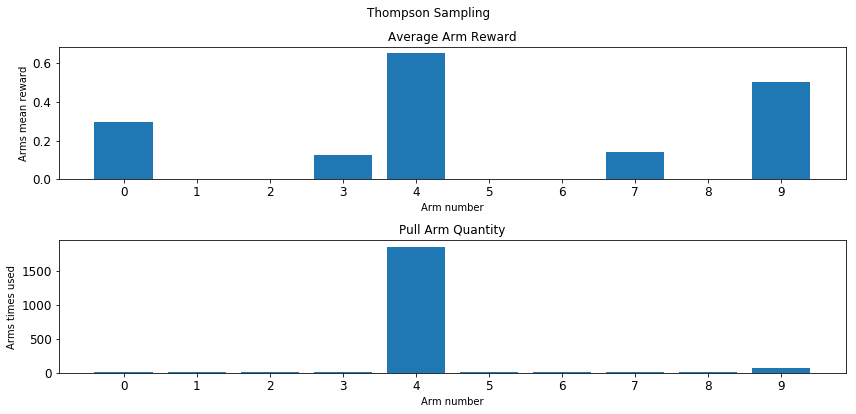

In [30]:
tsbandit.show_statistics("Thompson Sampling", color_thompson)

## Conclusion: Comparison Between All Bandit Algorithms

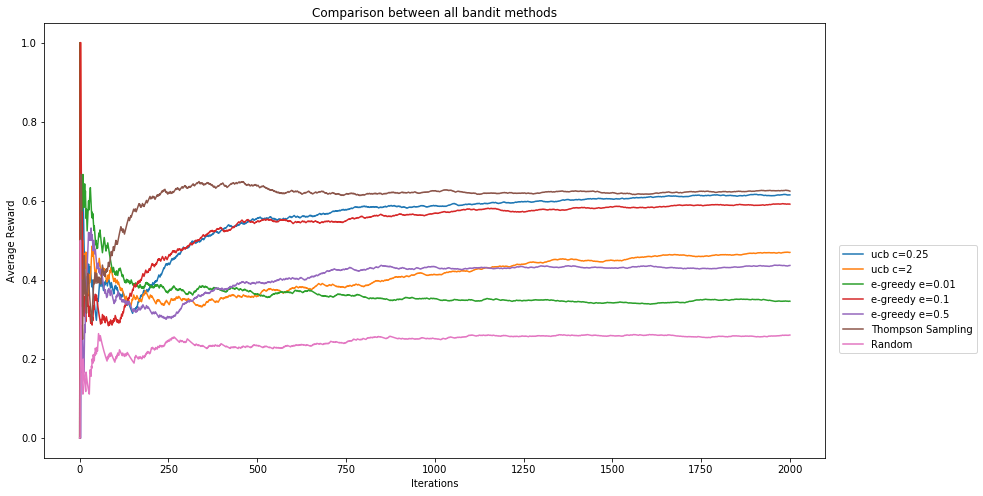

In [31]:
# plot rewards over the iteration
plt.figure(figsize=(14,8))
plt.title("Comparison between all bandit methods")

# ucb c=0.25 
plt.plot(results_ucb[0.25].reward, label="ucb c=0.25")

# ucb c=2
plt.plot(results_ucb[2].reward, label="ucb c=2")

# e-greedy e=0.01
plt.plot(results_eps[0.01].reward, label="e-greedy e=0.01")

# e-greedy e=0.1
plt.plot(results_eps[0.1].reward, label="e-greedy e=0.1")

# e-greedy e=0.5
plt.plot(results_eps[0.5].reward, label="e-greedy e=0.5")

# thompson sampling
plt.plot(tsbandit.reward, label="Thompson Sampling")
    
# random 
plt.plot(rand_b.reward, label="Random")


plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.show()